In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import missingno as msno
sns.set_palette('husl',9)

In [2]:
data = {
    'tra': pd.read_csv('air_visit_data.csv'),
    'as': pd.read_csv('air_store_info.csv'),
    'hs': pd.read_csv('hpg_store_info.csv'),
    'ar': pd.read_csv('air_reserve.csv'),
    'hr': pd.read_csv('hpg_reserve.csv'),
    'id': pd.read_csv('store_id_relation.csv'),
    'tes': pd.read_csv('sample_submission.csv'),
    'hol': pd.read_csv('date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }


# 6. store_id_relation

### 150개의 겹치는 가게 id

In [3]:
data['id'] 

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7
...,...,...
145,air_b8925441167c3152,hpg_0cc0abae3a8b52de
146,air_f8233ad00755c35c,hpg_098e4dd30e54fee6
147,air_6607fe3671242ce3,hpg_1004356dc8ab69ec
148,air_ccd19a5bc5573ae5,hpg_df22bf146d2c7e19


In [4]:
data['as']

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
...,...,...,...,...,...
824,air_9bf595ef095572fb,International cuisine,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
825,air_764f71040a413d4d,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
826,air_10bbe8acd943d8f6,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
827,air_7514d90009613cd6,Karaoke/Party,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956


In [5]:
data['hs']

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
...,...,...,...,...,...
4685,hpg_c6ed353a48c7c93e,Sichuan food,Tōkyō-to Chiyoda-ku None,35.695780,139.768453
4686,hpg_a58d2423360b2fb4,Sichuan food,Tōkyō-to Minato-ku Roppongi,35.666137,139.733978
4687,hpg_d2021704076cdd70,Shanghai food,Tōkyō-to Chiyoda-ku None,35.695780,139.768453
4688,hpg_602472570d65e219,Spain/Mediterranean cuisine,Tōkyō-to Toshima-ku None,35.730068,139.711742


## id 기준으로 store 정보 합치기

### air_store_info에 air_store_id와 일치하는 hpg_store_id 컬럼 대입

In [6]:
data['as'] = pd.merge(data['as'], data['id'], how='inner', on=['air_store_id'])
data['as']

,air_store_id,air_genre_name,air_area_name,latitude,longitude,hpg_store_id
0,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,hpg_9b38b9e13da6da27
1,air_290e7a57b390f78e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,hpg_c5ec63f52e4a7e9e
2,air_638c35eb25e53eea,Italian/French,Fukuoka-ken Fukuoka-shi Daimyō,33.589216,130.392813,hpg_f07ec7b288165b27
3,air_fcfbdcf7b1f82c6e,Italian/French,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,hpg_0b53e00789c2eafe
4,air_f8233ad00755c35c,Italian/French,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,hpg_098e4dd30e54fee6
...,...,...,...,...,...,...
145,air_2cee51fa6fdf6c0d,Western food,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,hpg_113fd6e4fa77800f
146,air_b45b8e456f53942a,Western food,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956,hpg_a85b37424291216b
147,air_0a74a5408a0b8642,Western food,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956,hpg_2ded824e690c414a
148,air_bedd35489e666605,Western food,Tōkyō-to Chūō-ku Tsukiji,35.670651,139.771861,hpg_8f5331198ed1781d


### 'hpg_store_id' 기준으로 air_store_info 와 hpg_store_info 합치기

In [7]:
store_merge = pd.merge(data['as'], data['hs'], how='left', on=['hpg_store_id']) 
store_merge.head(20)

,air_store_id,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_y,longitude_y
0,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,hpg_9b38b9e13da6da27,NaN,NaN,NaN,NaN
1,air_290e7a57b390f78e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,hpg_c5ec63f52e4a7e9e,NaN,NaN,NaN,NaN
2,air_638c35eb25e53eea,Italian/French,Fukuoka-ken Fukuoka-shi Daimyō,33.589216,130.392813,hpg_f07ec7b288165b27,Spain Bar/Italian Bar,Fukuoka-ken Fukuoka-shi Daimyō,33.586969,130.392801
3,air_fcfbdcf7b1f82c6e,Italian/French,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,hpg_0b53e00789c2eafe,Italian,Tōkyō-to Shibuya-ku None,35.659214,139.699736
4,air_f8233ad00755c35c,Italian/French,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,hpg_098e4dd30e54fee6,Spain Bar/Italian Bar,Tōkyō-to Shibuya-ku None,35.659214,139.699736
5,air_938ef91ecdde6878,Italian/French,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,hpg_623477d346cf1822,NaN,NaN,NaN,NaN
6,air_8e492076a1179383,Italian/French,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386245,132.455018,hpg_aee92538e1b51d5f,NaN,NaN,NaN,NaN
7,air_0867f7bebad6a649,Italian/French,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386245,132.455018,hpg_caf1082b9f445c7b,NaN,NaN,NaN,NaN
8,air_900d755ebd2f7bbd,Italian/French,Tōkyō-to Chūō-ku Ginza,35.672114,139.770825,hpg_2864fa16b03e3813,NaN,NaN,NaN,NaN
9,air_ccd19a5bc5573ae5,Italian/French,Tōkyō-to Shinjuku-ku Kabukichō,35.693840,139.703549,hpg_df22bf146d2c7e19,NaN,NaN,NaN,NaN


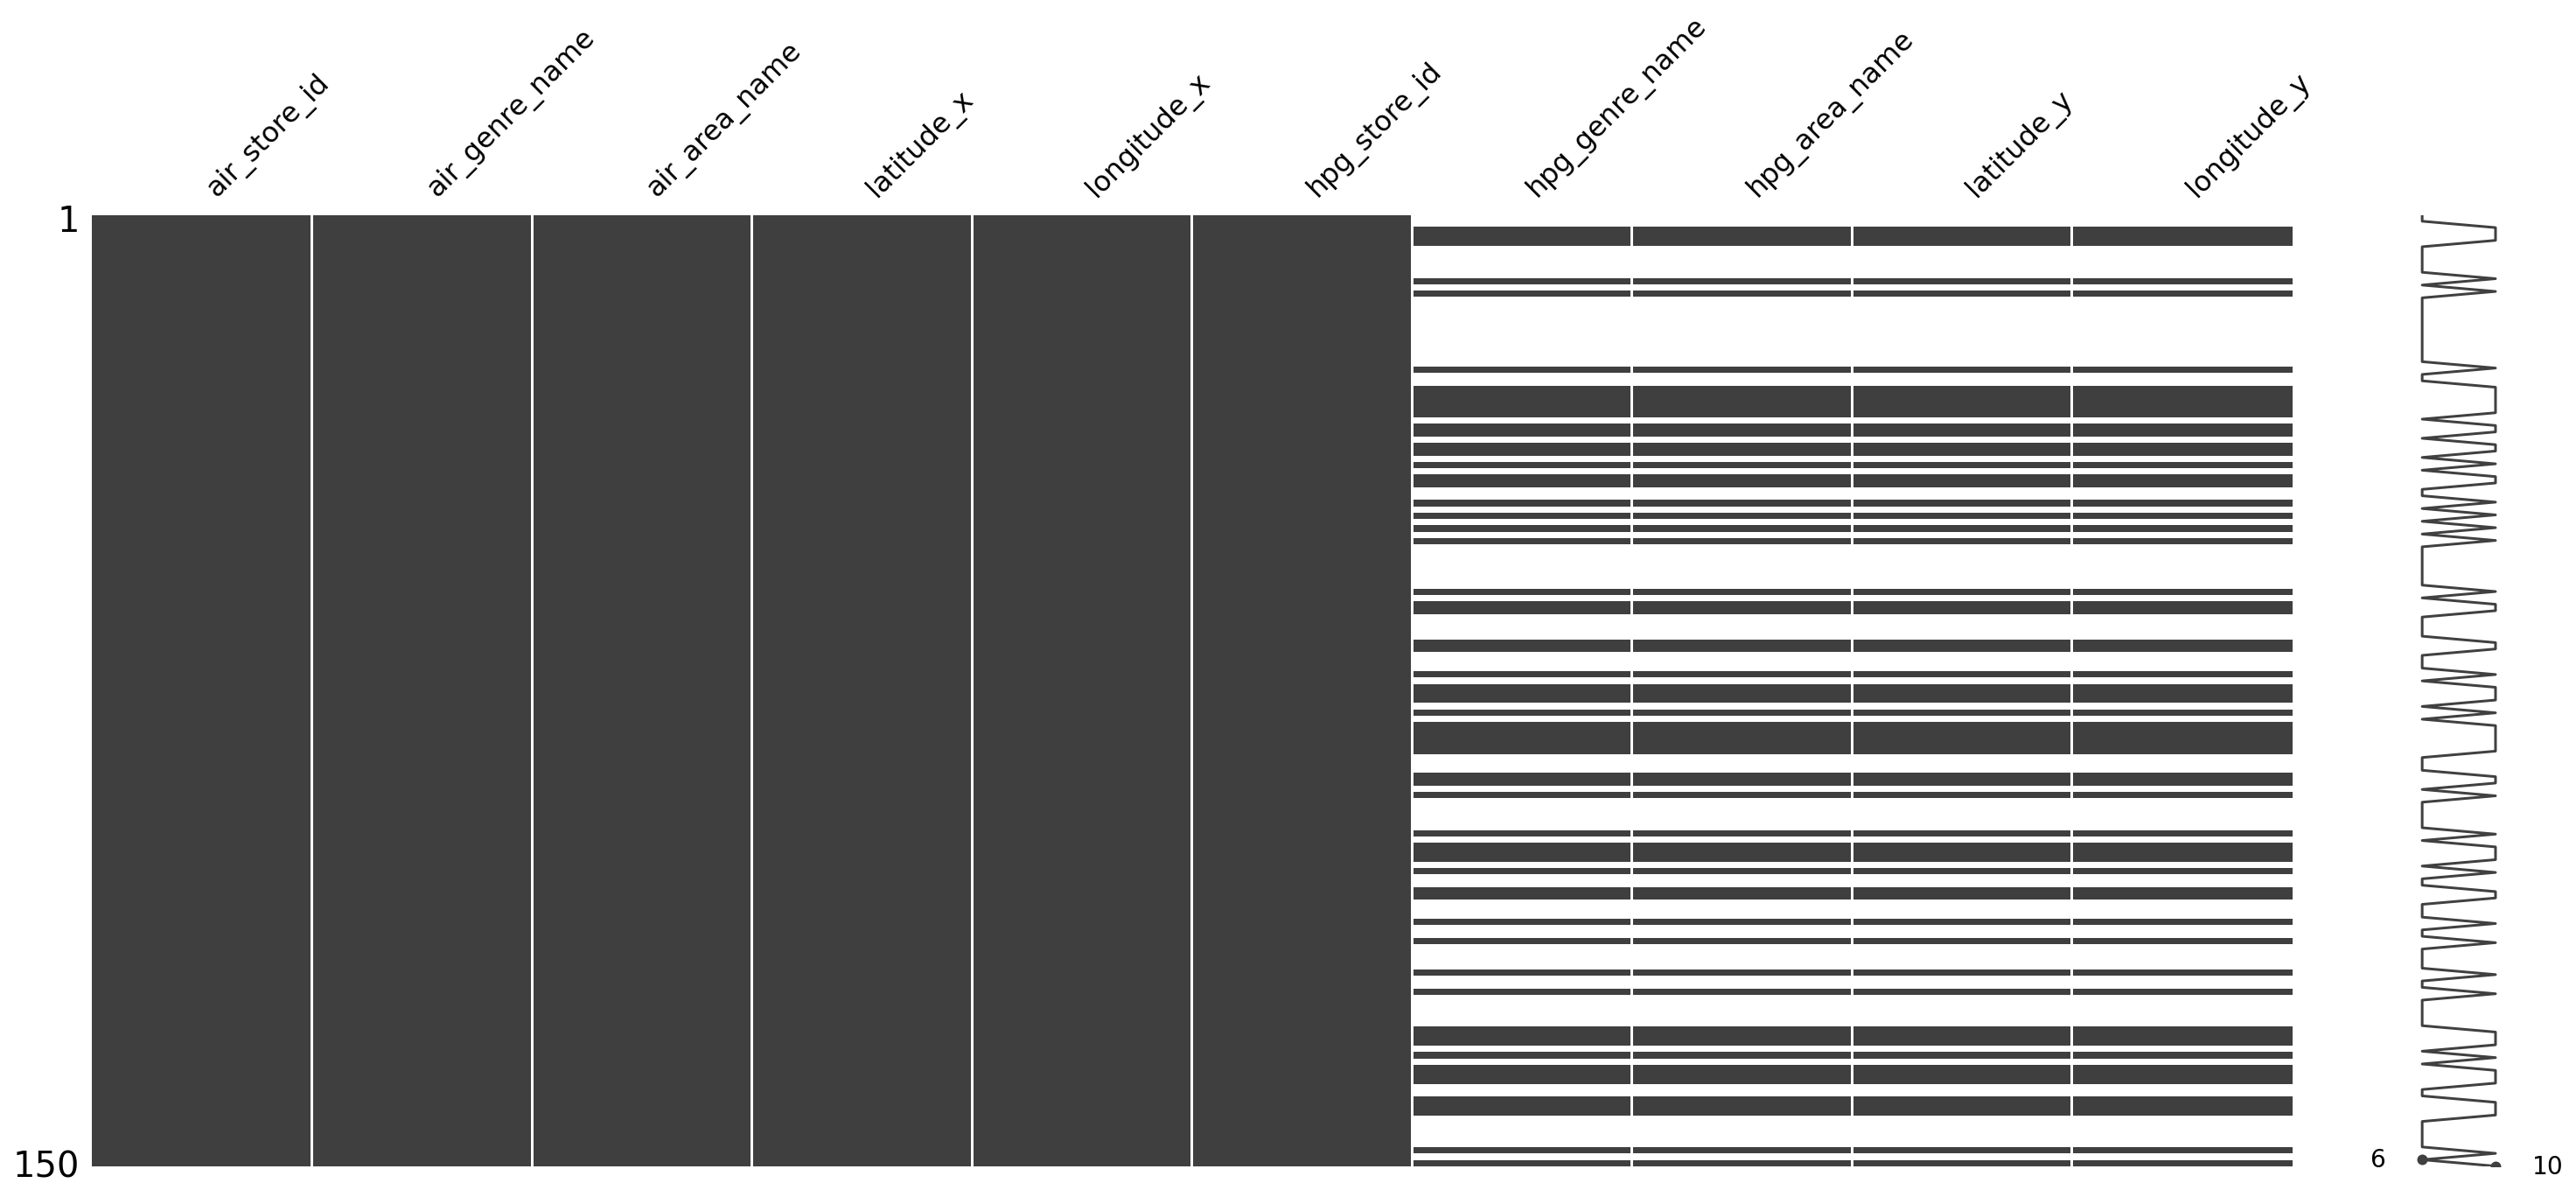

In [8]:
msno.matrix(store_merge)

In [9]:
store_merge.isnull().sum()

air_store_id       0
air_genre_name     0
air_area_name      0
latitude_x         0
longitude_x        0
hpg_store_id       0
hpg_genre_name    87
hpg_area_name     87
latitude_y        87
longitude_y       87
dtype: int64

### => hpg store 정보에 null값이 많이 보임

In [10]:
store_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   air_store_id    150 non-null    object 
 1   air_genre_name  150 non-null    object 
 2   air_area_name   150 non-null    object 
 3   latitude_x      150 non-null    float64
 4   longitude_x     150 non-null    float64
 5   hpg_store_id    150 non-null    object 
 6   hpg_genre_name  63 non-null     object 
 7   hpg_area_name   63 non-null     object 
 8   latitude_y      63 non-null     float64
 9   longitude_y     63 non-null     float64
dtypes: float64(4), object(6)
memory usage: 12.9+ KB


### 그 중 Null값인 row만 확인

In [11]:
store_null =store_merge.loc[store_merge["hpg_genre_name"].isnull()]
store_null

,air_store_id,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_y,longitude_y
0,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,hpg_9b38b9e13da6da27,NaN,NaN,NaN,NaN
1,air_290e7a57b390f78e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,hpg_c5ec63f52e4a7e9e,NaN,NaN,NaN,NaN
5,air_938ef91ecdde6878,Italian/French,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,hpg_623477d346cf1822,NaN,NaN,NaN,NaN
6,air_8e492076a1179383,Italian/French,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386245,132.455018,hpg_aee92538e1b51d5f,NaN,NaN,NaN,NaN
7,air_0867f7bebad6a649,Italian/French,Hiroshima-ken Hiroshima-shi Kokutaijimachi,34.386245,132.455018,hpg_caf1082b9f445c7b,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
143,air_4c727b55acdee495,Creative cuisine,Hyōgo-ken Himeji-shi Yasuda,34.815149,134.685353,hpg_26d20b9f926ff5e9,NaN,NaN,NaN,NaN
144,air_fea5dc9594450608,Other,Shizuoka-ken Hamamatsu-shi Motoshirochō,34.710895,137.725940,hpg_6507818140022452,NaN,NaN,NaN,NaN
145,air_2cee51fa6fdf6c0d,Western food,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051,hpg_113fd6e4fa77800f,NaN,NaN,NaN,NaN
146,air_b45b8e456f53942a,Western food,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956,hpg_a85b37424291216b,NaN,NaN,NaN,NaN


In [12]:
data['hs'].loc[data['hs']['hpg_store_id']=='hpg_9b38b9e13da6da27']

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude


In [13]:
data['as'].loc[data['as']['air_store_id']=='air_7cc17a324ae5c7dc']

,air_store_id,air_genre_name,air_area_name,latitude,longitude,hpg_store_id
0,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852,hpg_9b38b9e13da6da27


### => hpg store 정보가 없는  hpg store id 들이 존재했기 때문..
### => 같은 가게인데도 air_store_info에는 존재하고 hpg_store_info 에는 존재하지 않는 경우가 있다.

In [14]:
#store_null['hpg_store_id'][5]

***

# 7. date_info

In [15]:
data['hol']

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0
...,...,...,...
512,2017-05-27,Saturday,0
513,2017-05-28,Sunday,0
514,2017-05-29,Monday,0
515,2017-05-30,Tuesday,0


In [16]:
# 휴일만
holiday=data['hol'].loc[data['hol']['holiday_flg'] ==1]
holiday

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
10,2016-01-11,Monday,1
41,2016-02-11,Thursday,1
79,2016-03-20,Sunday,1
80,2016-03-21,Monday,1
119,2016-04-29,Friday,1
123,2016-05-03,Tuesday,1
124,2016-05-04,Wednesday,1


In [17]:
holiday['day_of_week'].value_counts()  # 공휴일인 날의 요일 분포 확인 (공휴일은 월,화인 날이 많았다.)

Monday       9
Thursday     7
Saturday     5
Friday       5
Sunday       4
Wednesday    3
Tuesday      2
Name: day_of_week, dtype: int64

In [18]:
# 날짜 데이터 타입으로 변경
data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])

In [19]:
# 4월말에서 5월의 데이터를 2016년/2017년 따로 추출
holidays16 = data['hol'][((data['hol']['visit_date'] >'2016-04-15') & (data['hol']['visit_date'] < '2016-06-01'))]
holidays17 = data['hol'][((data['hol']['visit_date'] >'2017-04-15') & (data['hol']['visit_date'] < '2017-06-01'))]

In [20]:
holidays16

,visit_date,day_of_week,holiday_flg
106,2016-04-16,Saturday,0
107,2016-04-17,Sunday,0
108,2016-04-18,Monday,0
109,2016-04-19,Tuesday,0
110,2016-04-20,Wednesday,0
111,2016-04-21,Thursday,0
112,2016-04-22,Friday,0
113,2016-04-23,Saturday,0
114,2016-04-24,Sunday,0
115,2016-04-25,Monday,0


## 공휴일과 아닌 날의 count 비교

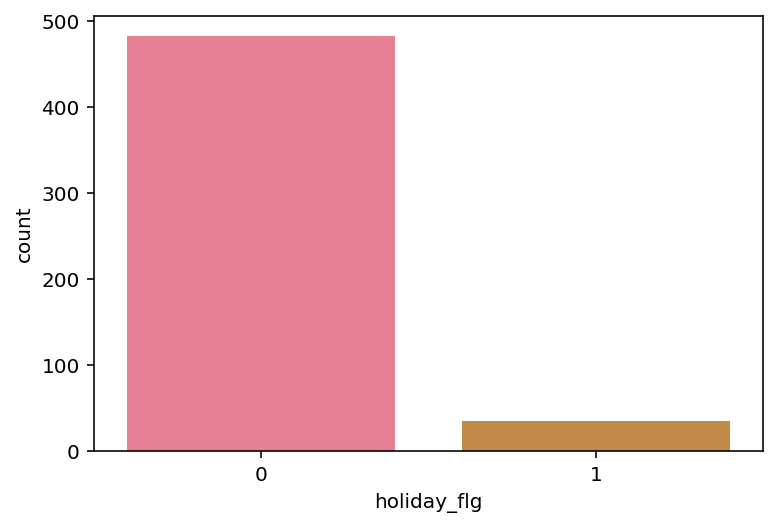

In [21]:
sns.countplot(x="holiday_flg",data = data['hol']) 

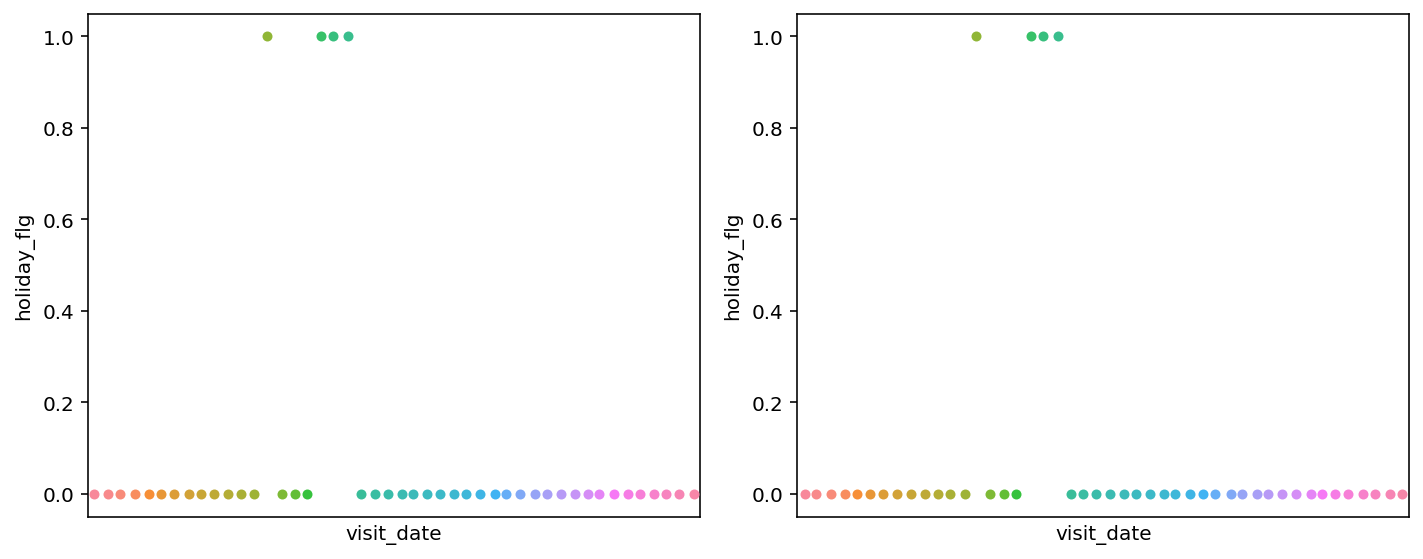

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2,figsize=(10,4))
plt2 = sns.stripplot(x='visit_date',y='holiday_flg',data=holidays16, ax=ax1)
plt2.set_xticks([])

plt3 = sns.stripplot(x='visit_date',y='holiday_flg',data=holidays17, ax=ax2)
plt3.set(xticks=[])

plt.tight_layout()

- 2016년 4월 말과 5월은 2017년과 휴일이 같다. (4/29, 5/3,5/4,5/5)
- data에서 휴일의 비율은 대략 7%이다.

## 공휴일여부에 따른 방문객평균

In [23]:
data['hol']

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0
...,...,...,...
512,2017-05-27,Saturday,0
513,2017-05-28,Sunday,0
514,2017-05-29,Monday,0
515,2017-05-30,Tuesday,0


In [24]:
data['tra']

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6
...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6
252104,air_24e8414b9b07decb,2017-04-19,6
252105,air_24e8414b9b07decb,2017-04-20,7
252106,air_24e8414b9b07decb,2017-04-21,8


In [25]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])

In [26]:
tra_hol_merge = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date'])
tra_hol_merge

,air_store_id,visit_date,visitors,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0
...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,Tuesday,0
252104,air_24e8414b9b07decb,2017-04-19,6,Wednesday,0
252105,air_24e8414b9b07decb,2017-04-20,7,Thursday,0
252106,air_24e8414b9b07decb,2017-04-21,8,Friday,0


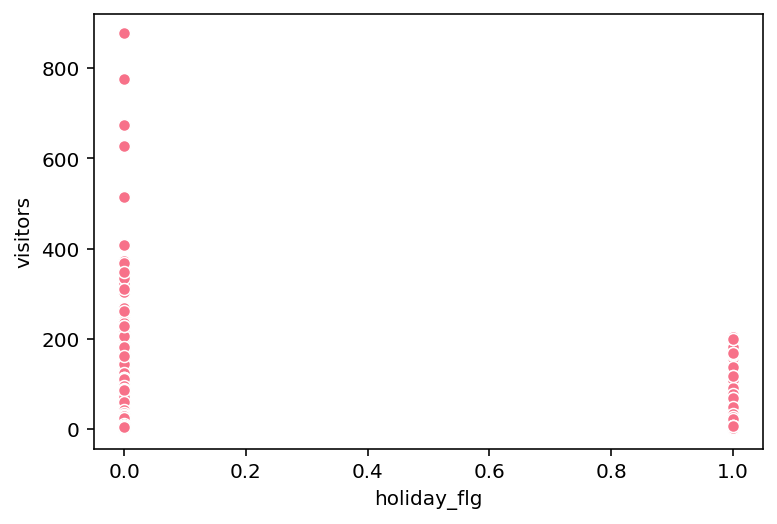

In [27]:
sns.scatterplot(x='holiday_flg',y='visitors',data=tra_hol_merge)

* 방문객이 400명을 넘는 경우는 공휴일이 아닌 날에 많이 존재함.

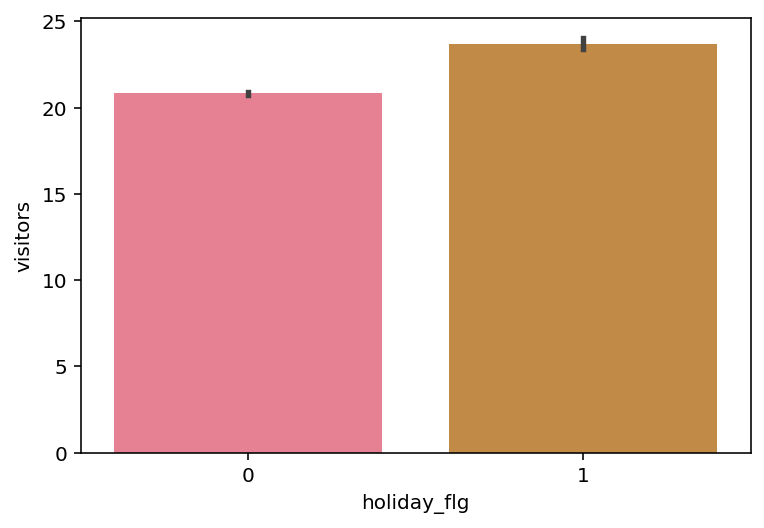

In [28]:
sns.barplot(x='holiday_flg',y='visitors',data=tra_hol_merge)

* 하지만 평균 방문자수는 공휴일일때 더 많다.

### 공휴일 요일에 따른 방문자평균

In [29]:
tra_holiday_merge = pd.merge(data['tra'],data['hol'], how='left', on=['visit_date'])
tra_holiday_merge

,air_store_id,visit_date,visitors,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0
...,...,...,...,...,...
252103,air_24e8414b9b07decb,2017-04-18,6,Tuesday,0
252104,air_24e8414b9b07decb,2017-04-19,6,Wednesday,0
252105,air_24e8414b9b07decb,2017-04-20,7,Thursday,0
252106,air_24e8414b9b07decb,2017-04-21,8,Friday,0


In [30]:
onlyhol=tra_holiday_merge.loc[tra_holiday_merge['holiday_flg']==1]

In [31]:
pvt3=onlyhol.groupby(['day_of_week'])['visitors'].mean().reset_index()

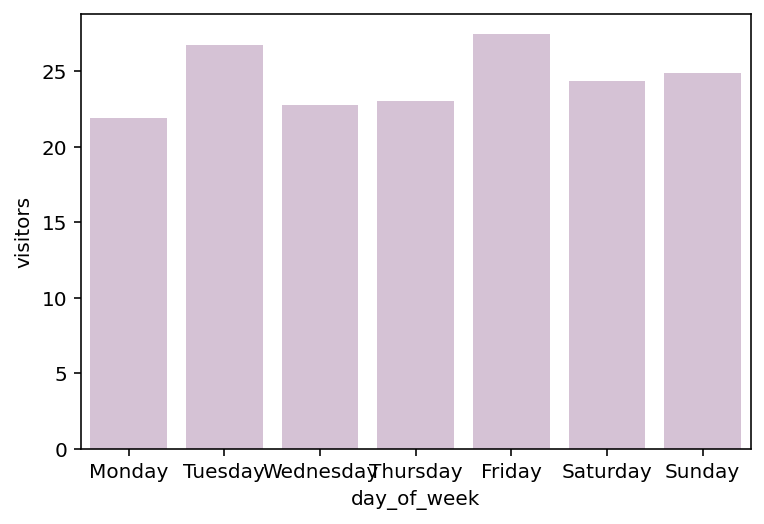

In [32]:
sns.barplot(pvt3['day_of_week'] ,pvt3['visitors'],color='thistle',order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday','Sunday'])

* 화요일,금요일이 공휴일일때, 평균방문자수가 제일 많았다.

## 공휴일여부에 따른 air예약자 평균

In [33]:
data['ar']

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5
...,...,...,...,...
92373,air_db4b38ebe7a7ceff,2017-05-29 18:00:00,2017-04-17 19:00:00,6
92374,air_1033310359ceeac1,2017-05-30 23:00:00,2017-04-19 17:00:00,8
92375,air_877f79706adbfb06,2017-05-31 20:00:00,2017-04-12 23:00:00,3
92376,air_900d755ebd2f7bbd,2017-05-31 20:00:00,2017-04-19 16:00:00,10


In [34]:
data['ar']['visit_datetime'] = pd.to_datetime(data['ar']['visit_datetime'])
data['ar']['visit_datetime'] = data['ar']['visit_datetime'].dt.date

In [35]:
data['ar']=data['ar'].rename(columns={
            'visit_datetime': 'visit_date'
        })
data['ar']['visit_date'] = pd.to_datetime(data['ar']['visit_date'])

In [36]:
ar_hol_merge = pd.merge(data['ar'], data['hol'], how='left', on=['visit_date'])
ar_hol_merge

,air_store_id,visit_date,reserve_datetime,reserve_visitors,day_of_week,holiday_flg
0,air_877f79706adbfb06,2016-01-01,2016-01-01 16:00:00,1,Friday,1
1,air_db4b38ebe7a7ceff,2016-01-01,2016-01-01 19:00:00,3,Friday,1
2,air_db4b38ebe7a7ceff,2016-01-01,2016-01-01 19:00:00,6,Friday,1
3,air_877f79706adbfb06,2016-01-01,2016-01-01 16:00:00,2,Friday,1
4,air_db80363d35f10926,2016-01-01,2016-01-01 01:00:00,5,Friday,1
...,...,...,...,...,...,...
92373,air_db4b38ebe7a7ceff,2017-05-29,2017-04-17 19:00:00,6,Monday,0
92374,air_1033310359ceeac1,2017-05-30,2017-04-19 17:00:00,8,Tuesday,0
92375,air_877f79706adbfb06,2017-05-31,2017-04-12 23:00:00,3,Wednesday,0
92376,air_900d755ebd2f7bbd,2017-05-31,2017-04-19 16:00:00,10,Wednesday,0


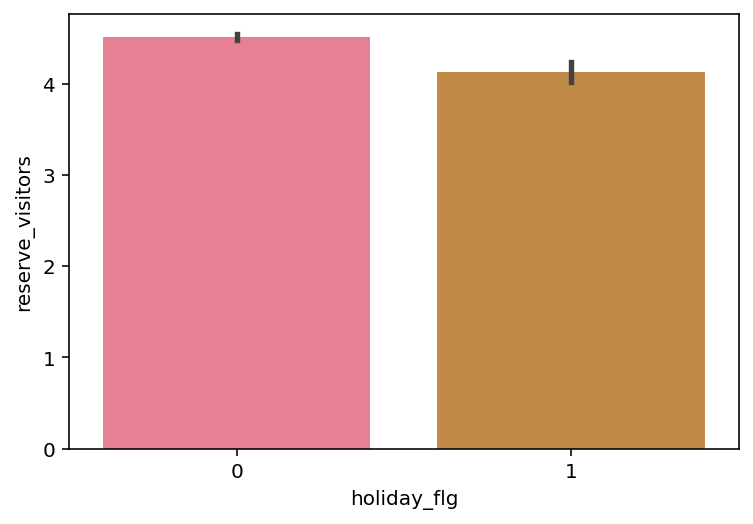

In [37]:
sns.barplot(x='holiday_flg',y='reserve_visitors',data=ar_hol_merge)

* air 평균 예약자 수는 공휴일이 아닌 날에 더 많다.

## 공휴일여부에 따른 hpg예약자 평균

In [38]:
data['hr']

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13
...,...,...,...,...
2000315,hpg_2b293477ea4642fb,2017-05-31 20:00:00,2017-04-19 07:00:00,2
2000316,hpg_f922aeca48ca5a29,2017-05-31 20:00:00,2017-03-19 00:00:00,3
2000317,hpg_e9151de687b93aa3,2017-05-31 21:00:00,2017-04-14 20:00:00,49
2000318,hpg_fae6c96189b4a122,2017-05-31 21:00:00,2017-04-19 17:00:00,9


In [39]:
data['hr']['visit_datetime'] = pd.to_datetime(data['hr']['visit_datetime'])
data['hr']['visit_datetime'] = data['hr']['visit_datetime'].dt.date

In [40]:
data['hr']=data['hr'].rename(columns={
            'visit_datetime': 'visit_date'
        })
data['hr']['visit_date'] = pd.to_datetime(data['hr']['visit_date'])

In [41]:
hr_hol_merge = pd.merge(data['hr'], data['hol'], how='left', on=['visit_date'])
hr_hol_merge

,hpg_store_id,visit_date,reserve_datetime,reserve_visitors,day_of_week,holiday_flg
0,hpg_c63f6f42e088e50f,2016-01-01,2016-01-01 09:00:00,1,Friday,1
1,hpg_dac72789163a3f47,2016-01-01,2016-01-01 06:00:00,3,Friday,1
2,hpg_c8e24dcf51ca1eb5,2016-01-01,2016-01-01 14:00:00,2,Friday,1
3,hpg_24bb207e5fd49d4a,2016-01-01,2016-01-01 11:00:00,5,Friday,1
4,hpg_25291c542ebb3bc2,2016-01-01,2016-01-01 03:00:00,13,Friday,1
...,...,...,...,...,...,...
2000315,hpg_2b293477ea4642fb,2017-05-31,2017-04-19 07:00:00,2,Wednesday,0
2000316,hpg_f922aeca48ca5a29,2017-05-31,2017-03-19 00:00:00,3,Wednesday,0
2000317,hpg_e9151de687b93aa3,2017-05-31,2017-04-14 20:00:00,49,Wednesday,0
2000318,hpg_fae6c96189b4a122,2017-05-31,2017-04-19 17:00:00,9,Wednesday,0


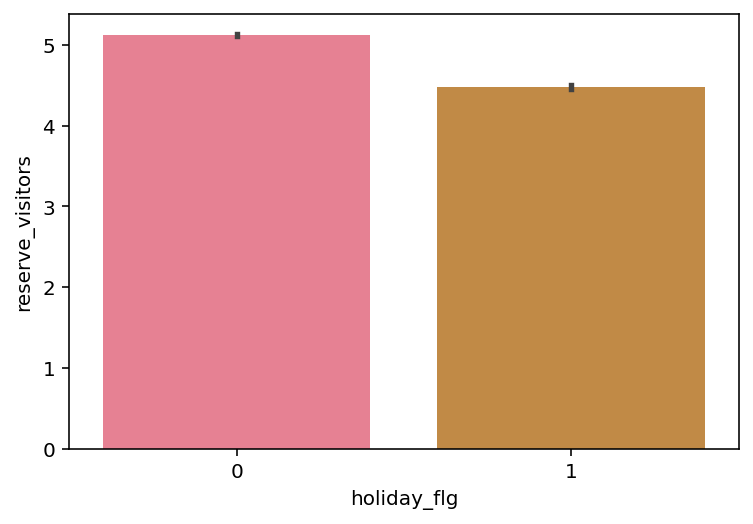

In [42]:
sns.barplot(x='holiday_flg',y='reserve_visitors',data=hr_hol_merge)

* hpg 평균 예약자 수는 공휴일이 아닌 날에 더 많다.